# Processamento de Linguagem Natural

***

## Importando bibliotecas

In [93]:
# Bibliotecas de manipualção e visualização de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

# Classes do modelo
from sklearn.linear_model import LogisticRegression

# Funções de avaliação dos modelos
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## Análise do conjunto de dados

**HatEval** : Este conjunto de dados faz parte da competição SemEval 2019 Task 5 [(Basile et al., 2019)](https://aclanthology.org/S19-2007.pdf) que consiste na detecção de discurso de ódio contra imigrantes e mulheres. Vamos consider apenas a subtarefa A English, um problema de classificação binária para detectar se um tweet em inglês contém discurso de ódio. Mais informações sobre o conjunto de dados HatEval podem ser encontradas em sua página do GitHub: https://github.com/msang/hateval.

In [115]:
# Esse dataset já é dividido em treinamento, teste e validação
train = pd.read_csv("https://raw.githubusercontent.com/gabrielh10/ml_practice_tutoring_2/master/Datasets/hateval/train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/gabrielh10/ml_practice_tutoring_2/master/Datasets/hateval/test.csv")
val = pd.read_csv("https://raw.githubusercontent.com/gabrielh10/ml_practice_tutoring_2/master/Datasets/hateval/val.csv")

HTTPError: HTTP Error 404: Not Found

Vamos observar algumas características de dataset

Quantidade de exemplos em cada conjunto

 TREINAMENTO: 9000

 TESTE: 3000

 VALIDAÇÃO: 1000

 Distribuição dos dados por classe


Text(0.5, 1.0, 'Validação')

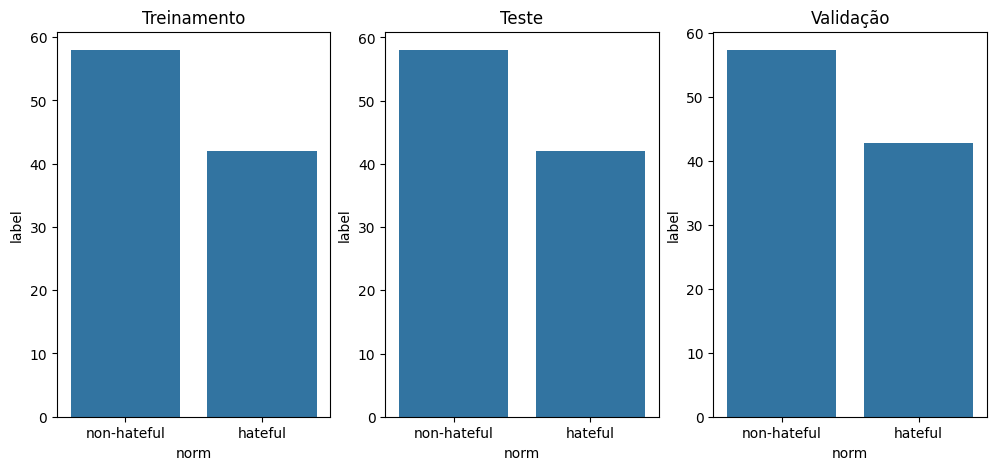

In [95]:
# Distribuição dos dados por
print("Quantidade de exemplos em cada conjunto")

print("\n TREINAMENTO:", train.shape[0])

print("\n TESTE:", test.shape[0])

print("\n VALIDAÇÃO:", val.shape[0])

print("\n Distribuição dos dados por classe")

fig, ax = plt.subplots(1,3, figsize=(12,5))
#percentual
sns.barplot(x="norm", y="label",  data=train,ax=ax[0], order=["non-hateful", "hateful"],  estimator=lambda x: len(x) / len(train) * 100)
ax[0].set_title("Treinamento")
sns.barplot(x="norm", y="label", data=test, ax=ax[1], order=["non-hateful", "hateful"], estimator=lambda x: len(x) / len(test) * 100)
ax[1].set_title("Teste")
sns.barplot(x="norm", y="label", data=val, ax=ax[2], order=["non-hateful", "hateful"], estimator=lambda x: len(x) / len(val) * 100)
ax[2].set_title("Validação")

# Se quiser visualizar a contagem
# sns.countplot(x="label", data=train, ax=ax[0])
# sns.countplot(x="label", data=test, ax=ax[1])
# sns.countplot(x="label", data=val, ax=ax[2])

# 58%: non-hateful
# 42%: hateful

**Vamos observar os dados**

* Features: texto em linguagem natural

* Características do texto: obtido a partir de redes sociais (Twitter). Possui alguns elementos como: menções (“i.e.,$@usuario$"), URLs ( “$http[s]://$"), RT símbolos, números e etc.




In [96]:
# primeiramente vamos observar os dados
with pd.option_context('display.max_colwidth',None):
  display(train.head(5))#

,index,text,label,norm
0,201,"Hurray, saving us $$$ in so many ways @potus @realDonaldTrump #LockThemUp #BuildTheWall #EndDACA #BoycottNFL #BoycottNike",1,hateful
1,202,"Why would young fighting age men be the vast majority of the ones escaping a war &amp; not those who cannot fight like women, children, and the elderly?It's because the majority of the refugees are not actually refugees they are economic migrants trying to get into Europe.... https://t.co/Ks0SHbtYqn",1,hateful
2,203,"@KamalaHarris Illegals Dump their Kids at the border like Road Kill and Refuse to Unite! They Hope they get Amnesty, Free Education and Welfare Illegal #FamilesBelongTogether in their Country not on the Taxpayer Dime Its a SCAM #NoDACA #NoAmnesty #SendThe",1,hateful
3,204,NY Times: 'Nearly All White' States Pose 'an Array of Problems' for Immigrants https://t.co/ACZKLhdMV9 https://t.co/CJAlSXCzR6,0,non-hateful
4,205,"Orban in Brussels: European leaders are ignoring the will of the people, they do not want migrants https://t.co/NeYFyqvYlX",0,non-hateful


## pré-processamento

A etapa de pré-processamento é responsável por preparar os dados para a etapa de extração de características.

Nessa etapa podem ser realizadas diferentes tarefas como:  

* Limpeza dos dados: remoção de menções (“i.e.,$@usuario$"), URLs ( “$http[s]://$"), RT símbolos, números, stop-words e espaços em branco redundantes.

* Normalização dos dados: conversão do texto completo para minúsculo e normalização de unicode [link](https://www.ibm.com/docs/en/db2-for-zos/11?topic=ccsids-normalization-unicode-strings).


Verificar a biblioteca [NLTK](https://www.nltk.org/)



In [97]:
# !pip install nltk

In [98]:
import nltk                                             # Natural Language Toolkit

nltk.download('stopwords')

import re                                               # biblioteca para operações com regular expression
from nltk.corpus import stopwords                       # módulo para tratamento das stop words que vem com o NLTK
import string                                           # para operações com string
from unicodedata import normalize                       # para normalização de unicodes

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [99]:
# se quiser visualizar a lista de stopwords
stops = set(stopwords.words('english'))
print(stops)
print("Quantidade: ",len(stops))
print("\n")
# os idiomas também podem ser usados
stops = set(stopwords.words('portuguese'))
print(stops)
print("Quantidade: ",len(stops))
print("\n")
stops = set(stopwords.words('spanish'))
print(stops)
print("Quantidade: ",len(stops))

{'not', 'other', "they're", 'yourselves', 'hasn', 'and', "mightn't", 'as', 'him', 'which', "i'm", "i'd", "doesn't", 'just', "he's", 'it', 'wouldn', 'her', 'you', 'can', 'have', 'yourself', 'then', "he'd", 'against', 'needn', "wasn't", 'he', "we'd", 'is', 'more', "he'll", 'theirs', 'am', 'haven', 'hers', 'they', 'any', 'y', 'ourselves', 'each', 'm', 't', "you'd", 'do', 'them', 'no', 'at', 'while', 'will', 're', 'up', "isn't", "we've", 'hadn', "mustn't", 'couldn', "she'll", 'this', 'll', 'that', 'nor', 'after', 'most', 'same', 'are', 'above', 'whom', 'she', 'all', "that'll", 'with', 'isn', 'again', "you've", 'themselves', 'of', "i'll", "wouldn't", 'those', 'about', 'under', "shan't", 'why', 'in', 'out', "hasn't", 'during', 'when', 'our', 'further', 've', "i've", 'an', "should've", 'doing', 'on', 'herself', "they've", 'ours', 'mustn', "you'll", 'his', 'own', 'didn', "haven't", "needn't", 'been', 'being', 'only', 'or', 'so', "it'll", "she'd", 'such', 'than', 'wasn', 'we', 'himself', "you'r

In [100]:
# vamos checar alguns exemplos
# Diferentes unicodes para gerar a mesma letra
print("\u00C7", "\u0043\u0327")

print("Ç" == "Ç")

print("Ç"=="Ç")

Ç Ç
False
True


In [101]:
def clear_replace(text):
    """
    1) Substituição de muitos espaços em branco por uma instância
    2) Remoção de RT, urls, menções, números
    3) Normalização de unicode

    Retorne o texto pré-processado
    """

    # padrão muitos espaços em branco
    space_pattern = '\s+'

    # padrão de RT
    rt_regex = 'RT @[\w_]+'

    # padrão para urls
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

    # padrão para menções
    mention_regex = '@[\w\-]+'

    #padrão para números
    number_regex = '[0-9]'

    # Removendo espaços extras
    parsed_text = re.sub(space_pattern, ' ', text)

    #Removendo RT
    parsed_text = re.sub(rt_regex, ' ', parsed_text)

    # Removendo URLs
    parsed_text = re.sub(giant_url_regex, ' ', parsed_text)

    # Removendo menções
    parsed_text = re.sub(mention_regex, ' ', parsed_text)

    # Removendo números
    parsed_text = re.sub(number_regex, ' ', parsed_text)

    # Normalização de unicode
    parsed_text = normalize('NFKD', parsed_text).encode('ASCII', 'ignore').decode('ASCII')

    return parsed_text

In [102]:
def to_lower(text):
  """ Transforme o texto em minúsculo"""
  return text.lower()

In [103]:
def remove_stopwords(text):
	""" Use NLTK para remover todas as stop-words em inglês """
	stop_words = set(stopwords.words('english'))  #portuguese

	return ' '.join([word for word in text.split() if word not in stop_words])

In [104]:
def pre_processing(tweets):
	clean_tweets = []

	for text in tweets:
		#Limpando o texto
		text = clear_replace(str(text))
		#Conversão do texto completo para minúsculo
		text = to_lower(text)
		# Removendo stopwords
		text = remove_stopwords(text)
		clean_tweets.append(text)
	return clean_tweets

In [105]:
# vamos verificar um exemplo. Vou colocar em português, mas para o HatEval dataset as stopwords devem ser em inglês.

exemplo_1 = "RT @chiquinho Quem te falou       ISSO?"

exemplo_2 = "ELA ama trabalhar com NLP 5 dias por semana https://www.nltk.org/"

tweets = [exemplo_1 , exemplo_2]

pre_processing(tweets)

['quem te falou isso?', 'ela ama trabalhar com nlp dias por semana']

In [106]:
seed = 42
# Vamos avaliar apenas um subset dos conjuntos de treinamento, teste e validação com 20% dos exemplos
train_sub, _, _,_ = train_test_split(train, train["label"], train_size=0.7, stratify=train["label"], random_state=seed)
test_sub, _, _,_ = train_test_split(test, test["label"], train_size=0.9, stratify=test["label"],  random_state=seed)
val_sub, _, _,_ = train_test_split(val, val["label"], train_size=0.9, stratify=val["label"], random_state=seed)

print(train_sub.shape[0])
print(test_sub.shape[0])
print(val_sub.shape[0])

6300
2700
900


In [107]:
train_sub["text"] = pre_processing(train_sub["text"])
test_sub["text"] = pre_processing(test_sub["text"])
val_sub["text"] = pre_processing(val_sub["text"])

X_train, y_train = train_sub["text"], train_sub["label"]
X_test, y_test = test_sub["text"], test_sub["label"]
X_val, y_val = val_sub["text"], val_sub["label"]

# primeiramente vamos observar os dados
with pd.option_context('display.max_colwidth',None):
  display(X_train.head(5))

,text
2326,"us govt one big crime scene, ie, wh, dhs, hhs, epa, etc. ongoing conspiracy state continues unabated. kidnapping immigrant children, illegal arrest &amp; imprisonment immigrants, theft federal funds nazi rallies, violating emoluments clause, tax scam."
7320,life gives lemons go masturbate take nap
6968,practicing homeless
7423,pro tip- never go someone food poisoning
4678,women making burritos jacksonville chipoltle!! eat there!! #womencantmakeburritos #sheforgottheguacamole #badburri!!


## Extração de características

Como representar uma palavra?

Em PLN os conjuntos de dados geralmente estão disponíveis como texto bruto para análise. Portanto, a extração de características visa transformar o texto em linguagem natural em um espaço vetorial numérico adequado como entradas do modelo. Várias técnicas de extração de características podem ser aplicadas, como técnicas de Bag-of-Words (BoW), recursos lexicais e métodos de embedding.

<!-- [Fonte](https://www.sciencedirect.com/science/article/pii/S1566253523004566?via%3Dihub) -->

<a href="https://www.sciencedirect.com/science/article/pii/S1566253523004566?via%3Dihub">
    <img src="https://raw.githubusercontent.com/johnattandouglas/monitoria-ml/main/imagens/featureExtraction.png" alt="Feature Extraction">
</a>

<!-- https://github.com/johnattandouglas/monitoria-ml/main/imagens/FeatureExtraction.png -->

Vamos utilizar o TF-IDF (frequency–inverse document frequency). O TF-IDF é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico.

$$TFIDF (t, d, D) = tf (t, d) \times idf (t, D)$$

tf - frequência absoluta

idf - A frequência inversa do documento é uma medida de quanta informação a palavra fornece, ou seja, se é comum ou rara em todos os documentos

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#For TF-IDF
#vectorizer = TfidfVectorizer()

#For Bag of Words
vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
X_val = vectorizer.transform(X_val)

In [109]:
feature_names = vectorizer.get_feature_names_out()
print(feature_names)
print("Número de features:", len(feature_names))

## com o pré-processamento: 4103
## sem o pré-processamento: 5182

['14' '2ythats' '______________________' ... 'zootopia' 'zwestern' 'zx']
Número de features: 13456


### Vamos avaliar o modelo usando a regressão logistica...

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(random_state=42)

# Configuração do GridSearchCV
param_grid = {
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'penalty': ['l1', 'l2', None],  # 'l1' só é suportado por 'liblinear' e 'saga'
    'max_iter': [100, 200, 300]
}

# Inicializa o GridSearchCV
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring='accuracy',          # métrica de avaliação
                    cv=5)                        # cross-validation

# Treinamento do GridSearchCV
grid.fit(X_train, y_train)

# Predição com o melhor modelo
y_pred = grid.predict(X_test)

# Exibe os melhores parâmetros
print("Melhor parâmetro:", grid.best_params_)

# Treinando o modelo final com os melhores parâmetros
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

# Predição final
y_pred = best_model.predict(X_test)

# Resultados do classificador
print(classification_report(y_test, y_pred))

Melhor parâmetro: {'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
              precision    recall  f1-score   support

           0       0.75      0.17      0.28      1566
           1       0.45      0.92      0.60      1134

    accuracy                           0.49      2700
   macro avg       0.60      0.55      0.44      2700
weighted avg       0.62      0.49      0.42      2700



In [111]:
#Acesssando os coeficientes da regressão logistica e ordenando-os
coefs = best_model.coef_[0]
sorted_indices = np.argsort(coefs)

# Palavras (Features) com os menores coeficientes na regressão logistica
print("Palavras com menores coeficientes:")
for i in sorted_indices[:5]:  # Pega as 5 primeiras
    print(f"  - {feature_names[i]}: {coefs[i]:.2f}")

print("\n")

# Palavras (Features) com os maiores coeficientes na regressão logistica
print("Palavras com maiores coeficientes:")
for i in sorted_indices[-5:]:  # Pega as 5 últimas
    print(f"  - {feature_names[i]}: {coefs[i]:.2f}")

Palavras com menores coeficientes:
  - ram: -1.96
  - son: -1.91
  - immigrant: -1.53
  - withrefugees: -1.34
  - rohingya: -1.27


Palavras com maiores coeficientes:
  - bitches: 2.01
  - hoes: 2.06
  - nodaca: 2.26
  - womensuck: 3.57
  - buildthatwall: 4.77


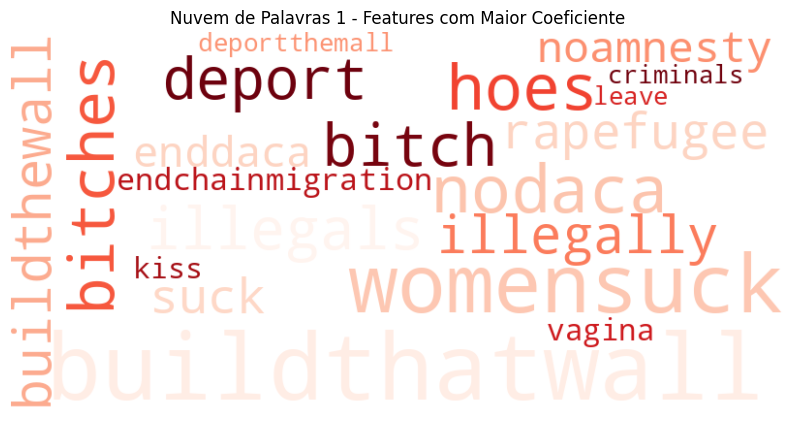

In [112]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

hate_speech_words_and_weights = {
    feature_names[i]: coefs[i] for i in sorted_indices[-20:]
}

# Configurações da nuvem de palavras
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds'
).generate_from_frequencies(hate_speech_words_and_weights)

# Exibir a nuvem de palavras
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras 1 - Features com Maior Coeficiente')
plt.show()

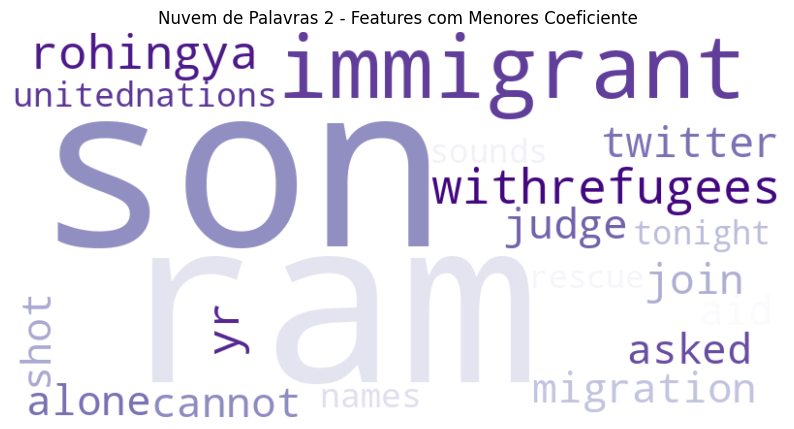

In [113]:
non_hate_words_and_weights = {
    feature_names[i]: abs(coefs[i]) for i in sorted_indices[:20]
}

# Configurações da nuvem de palavras
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Purples'
).generate_from_frequencies(non_hate_words_and_weights)

# Exibir a nuvem de palavras
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras 2 - Features com Menores Coeficiente')
plt.show()

### E se usarmos outras máquinas?

In [114]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Modelos a serem comparados
models = {
    'SVC': SVC(random_state=seed),
    'DecisionTree': DecisionTreeClassifier(random_state=seed)
}

# Parâmetros para cada modelo
param_grids = {
    'SVC': {
        'C': [0.1, 1, 10, 100],               # Parâmetro de regularização
        'kernel': ['linear', 'rbf', 'poly'],  # Tipos de kernel
        'gamma': ['scale', 'auto']
    },
    'DecisionTree': {
        'criterion': ['gini', 'entropy'],  # Critérios de divisão
        'max_depth': [None, 10, 20, 30],   # Profundidade máxima
        'min_samples_split': [2, 10, 20]   # Mínimo de amostras para dividir
    }
}

# Loop para treinar e avaliar cada modelo com GridSearchCV
for model_name, model in models.items():
    print(f"\nTreinando e avaliando o modelo: {model_name}")

    grid = GridSearchCV(estimator=model,
                        param_grid=param_grids[model_name],
                        scoring='accuracy',
                        cv=5)

    grid.fit(X_train, y_train)

    # Predição com o melhor modelo
    y_pred = grid.predict(X_test)

    # Exibe os melhores parâmetros
    print("Melhor parâmetro:", grid.best_params_)

    # Resultados do classificador
    print(classification_report(y_test, y_pred))


Treinando e avaliando o modelo: SVC
Melhor parâmetro: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.66      0.16      0.26      1566
           1       0.43      0.89      0.58      1134

    accuracy                           0.47      2700
   macro avg       0.55      0.52      0.42      2700
weighted avg       0.57      0.47      0.40      2700


Treinando e avaliando o modelo: DecisionTree
Melhor parâmetro: {'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 20}
              precision    recall  f1-score   support

           0       0.62      0.19      0.30      1566
           1       0.43      0.84      0.57      1134

    accuracy                           0.46      2700
   macro avg       0.53      0.52      0.43      2700
weighted avg       0.54      0.46      0.41      2700

